In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %pip install xgboost==1.5.0

***
### Funções

In [3]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [4]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

In [5]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

***
## Coleta de dados

In [6]:
FILE = "/kaggle/input/datasetsnew/pca_tem_clientes_iphone.csv"

In [7]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [8]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
    new_clients = new_clients.sample(frac = 0.01)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [9]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.age': 'idade'})\
             .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'a.avg_cpf': 'avg_cpf'})\
             .rename(columns={'a.peso_aparelho': 'peso_aparelho'})\
             .rename(columns={'a.update_software': 'update_software'})\
#              .drop_duplicates().reset_index(drop=True)

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5511981579717,724101811662198,35383610,2019-11-24,NaN,34,2,0,APPLE,IPHONE 11 PRO (A2215),...,119.99,0,1,0,2019,45.0,0.0,0.0,2215,1
1,5581986995622,724118112766250,35726509,2020-11-22,NaN,22,1,0,APPLE,IPHONE XS MAX (A1921),...,0.00,0,1,0,2018,49.0,0.0,0.0,1921,1
2,5567996132158,724066613576564,35531608,2021-09-24,NaN,12,1,0,APPLE,IPHONE 7 (A1778),...,0.00,0,1,0,2016,49.0,0.0,0.0,1778,0
3,5511997660598,724100103548508,35380408,2020-09-21,NaN,24,2,0,APPLE,IPHONE 7 (A1778),...,78.99,0,1,0,2016,30.0,0.0,0.0,1778,0
4,5575999213774,724117296649925,35670808,2021-12-23,NaN,9,0,0,APPLE,IPHONE 8 PLUS GSM (A1864),...,45.99,0,1,0,2017,31.0,0.0,0.0,1864,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58467,5521993420659,724112907130402,35654310,2021-01-10,NaN,21,1,0,APPLE,IPHONE 11 (A2111),...,70.40,0,1,0,2019,35.0,0.0,0.0,2111,1
58468,5518997132770,724102111060418,35608309,2021-12-27,NaN,9,0,0,APPLE,IPHONE 8 (A1905),...,62.01,0,1,0,2018,61.0,0.0,0.0,1905,1
58469,5551999657014,724065303216723,35967657,2021-12-03,NaN,10,0,0,APPLE,IPHONE 12 (A2403),...,399.99,0,0,1,2020,73.0,0.0,0.0,2403,1
58470,5579996378196,724117209653110,35569407,2020-01-18,NaN,33,2,0,APPLE,IPHONE 6S (A1688),...,56.99,0,1,0,2015,44.0,0.0,0.0,1688,0


### Limpeza dos dados

In [10]:
just_check_nan(dados)

Dados com NaN:
dt_fim                     49792
citydesc                   58472
statedesc                      2
subscribermainofferdesc      173
assignedchargeamount         166
dtype: int64

columns_with_nan.shape (5,)



In [11]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade'])\
                    .reset_index(drop=True)
# dados_droped

In [12]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      49686
citydesc    58296
dtype: int64

columns_with_nan.shape (2,)



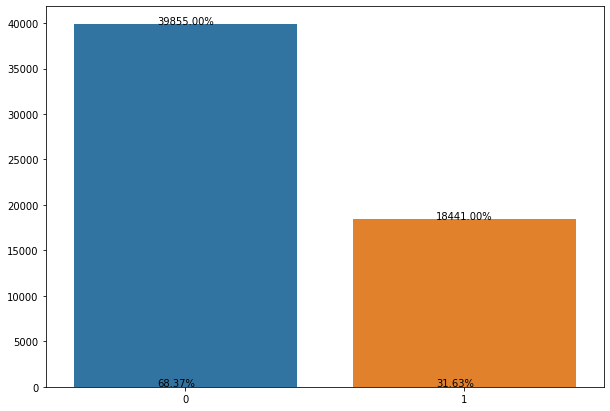

In [13]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

### Equilibrando classes

In [14]:
# dados_droped_0 = dados_droped[dados_droped['trocou_aparelho'] == 0].sample(frac=0.35, random_state=3)
# dados_droped_1 = dados_droped[dados_droped['trocou_aparelho'] == 1]

In [15]:
# dados_droped = pd.concat([dados_droped_0, dados_droped_1]).reset_index(drop=True).sort_values(by='msisdn', ascending=False)
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5511981579717,724101811662198,35383610,2019-11-24,NaN,34,2,0,APPLE,IPHONE 11 PRO (A2215),...,119.99,0,1,0,2019,45.0,0.0,0.0,2215,1
1,5581986995622,724118112766250,35726509,2020-11-22,NaN,22,1,0,APPLE,IPHONE XS MAX (A1921),...,0.00,0,1,0,2018,49.0,0.0,0.0,1921,1
2,5567996132158,724066613576564,35531608,2021-09-24,NaN,12,1,0,APPLE,IPHONE 7 (A1778),...,0.00,0,1,0,2016,49.0,0.0,0.0,1778,0
3,5511997660598,724100103548508,35380408,2020-09-21,NaN,24,2,0,APPLE,IPHONE 7 (A1778),...,78.99,0,1,0,2016,30.0,0.0,0.0,1778,0
4,5575999213774,724117296649925,35670808,2021-12-23,NaN,9,0,0,APPLE,IPHONE 8 PLUS GSM (A1864),...,45.99,0,1,0,2017,31.0,0.0,0.0,1864,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58291,5521993420659,724112907130402,35654310,2021-01-10,NaN,21,1,0,APPLE,IPHONE 11 (A2111),...,70.40,0,1,0,2019,35.0,0.0,0.0,2111,1
58292,5518997132770,724102111060418,35608309,2021-12-27,NaN,9,0,0,APPLE,IPHONE 8 (A1905),...,62.01,0,1,0,2018,61.0,0.0,0.0,1905,1
58293,5551999657014,724065303216723,35967657,2021-12-03,NaN,10,0,0,APPLE,IPHONE 12 (A2403),...,399.99,0,0,1,2020,73.0,0.0,0.0,2403,1
58294,5579996378196,724117209653110,35569407,2020-01-18,NaN,33,2,0,APPLE,IPHONE 6S (A1688),...,56.99,0,1,0,2015,44.0,0.0,0.0,1688,0


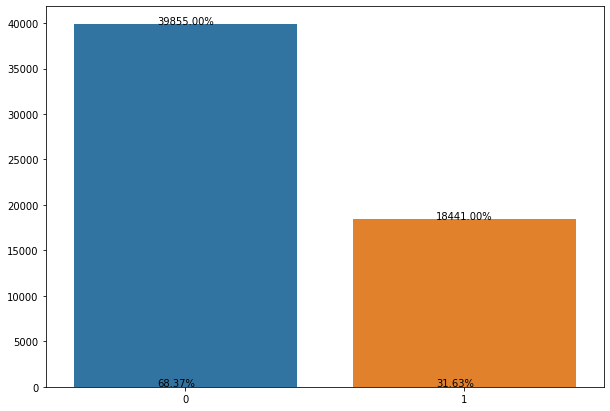

In [16]:
plot_feature_freq(dados_droped, 'trocou_aparelho')

In [17]:
# dados_droped = dados_droped.tail(dados_droped.shape[0] -230000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_droped['idade'] = np.asarray(dados_droped['idade'], dtype = 'int16')
dados_droped['fl_3g'] = np.asarray(dados_droped['fl_3g'], dtype = 'int8')
dados_droped['fl_4g'] = np.asarray(dados_droped['fl_4g'], dtype = 'int8')
dados_droped['fl_5g'] = np.asarray(dados_droped['fl_5g'], dtype = 'int8')
# dados_droped2 = dados_droped[dados_droped['trocou_aparelho'] == 1].reset_index()
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5511981579717,724101811662198,35383610,2019-11-24,NaN,34,2,0,APPLE,IPHONE 11 PRO (A2215),...,119.99,0,1,0,2019,45,0.0,0.0,2215,1
1,5581986995622,724118112766250,35726509,2020-11-22,NaN,22,1,0,APPLE,IPHONE XS MAX (A1921),...,0.00,0,1,0,2018,49,0.0,0.0,1921,1
2,5567996132158,724066613576564,35531608,2021-09-24,NaN,12,1,0,APPLE,IPHONE 7 (A1778),...,0.00,0,1,0,2016,49,0.0,0.0,1778,0
3,5511997660598,724100103548508,35380408,2020-09-21,NaN,24,2,0,APPLE,IPHONE 7 (A1778),...,78.99,0,1,0,2016,30,0.0,0.0,1778,0
4,5575999213774,724117296649925,35670808,2021-12-23,NaN,9,0,0,APPLE,IPHONE 8 PLUS GSM (A1864),...,45.99,0,1,0,2017,31,0.0,0.0,1864,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58291,5521993420659,724112907130402,35654310,2021-01-10,NaN,21,1,0,APPLE,IPHONE 11 (A2111),...,70.40,0,1,0,2019,35,0.0,0.0,2111,1
58292,5518997132770,724102111060418,35608309,2021-12-27,NaN,9,0,0,APPLE,IPHONE 8 (A1905),...,62.01,0,1,0,2018,61,0.0,0.0,1905,1
58293,5551999657014,724065303216723,35967657,2021-12-03,NaN,10,0,0,APPLE,IPHONE 12 (A2403),...,399.99,0,0,1,2020,73,0.0,0.0,2403,1
58294,5579996378196,724117209653110,35569407,2020-01-18,NaN,33,2,0,APPLE,IPHONE 6S (A1688),...,56.99,0,1,0,2015,44,0.0,0.0,1688,0


In [18]:
dados_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58296 entries, 0 to 58295
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   msisdn                   58296 non-null  int64  
 1   imsi                     58296 non-null  object 
 2   tac                      58296 non-null  int64  
 3   dt_inicio                58296 non-null  object 
 4   dt_fim                   8610 non-null   object 
 5   aging_aparelho           58296 non-null  int64  
 6   cat_aparelho             58296 non-null  int64  
 7   trocou_aparelho          58296 non-null  int64  
 8   fabricante               58296 non-null  object 
 9   modelo                   58296 non-null  object 
 10  imei                     58296 non-null  object 
 11  ranking                  58296 non-null  int64  
 12  cpfidentifier            58296 non-null  float64
 13  subscriberkey            58296 non-null  int64  
 14  customerkey           

***
## Mostrando a correlação entre os dados numéricos

In [19]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking', 
                                     'offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade',  'avg_msisdn', 'avg_cpf',
                                     'peso_aparelho', 'update_software', 'trocou_aparelho', 'aging_aparelho']]

<AxesSubplot:>

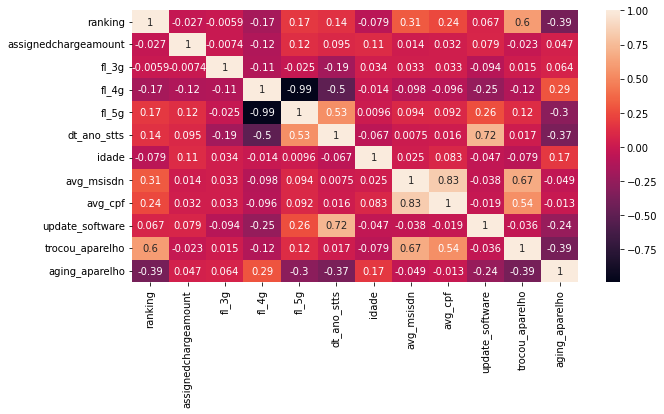

In [20]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

#### Correlação entre Meses do ano com Troca de Aparelho

In [21]:
dados_droped['mes_jan'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-01') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-01')

dados_droped['mes_fev'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-02') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-02')

dados_droped['mes_mar'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-03') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-03')

dados_droped['mes_abr'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-04') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-04')

dados_droped['mes_mai'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-05') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-05')

dados_droped['mes_jun'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-06') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-06')

dados_droped['mes_jul'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-07') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-07')  
                                                
dados_droped['mes_ago'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-08') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-08')

dados_droped['mes_set'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-09') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-09')

dados_droped['mes_out'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-10') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-10')

dados_droped['mes_nov'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-11') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-11')

dados_droped['mes_dez'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-12') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-12')

In [22]:
corr_meses_troca = dados_droped[['mes_jan', 'mes_fev', 'mes_mar', 'mes_abr', 
                                 'mes_mai', 'mes_jun', 'mes_jul', 'mes_ago', 
                                 'mes_set', 'mes_out', 'mes_nov', 'mes_dez', 'trocou_aparelho']]

<AxesSubplot:>

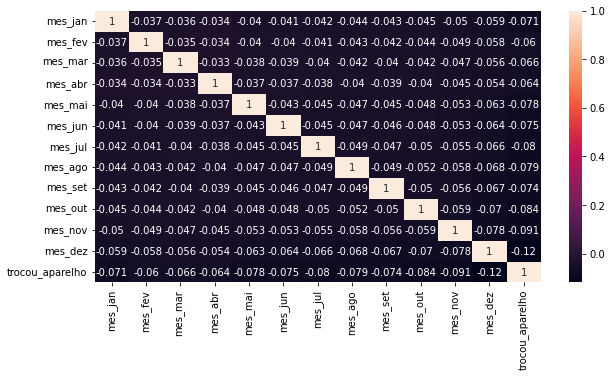

In [23]:
corr_Test = corr_meses_troca.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_Test, xticklabels = corr_Test.columns, yticklabels = corr_Test.columns, annot = True)

***
## Exploração dos dados

### seleção de features

In [24]:
# define features
X_ta = dados_droped[['fabricante', 'modelo', 'ranking', 'aging_aparelho', 
                     'offertechnology', 
                     'statedesc', 'subscribermainofferdesc', 'assignedchargeamount', 
                     'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf', 'peso_aparelho', 'update_software']]
X_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,APPLE,IPHONE 11 PRO (A2215),1,34,PostPaid,SAO PAULO,TITULAR VIVO POS 20GB - MENSAL,119.99,0,1,0,2019,45,0.0,0.0,2215,1
1,APPLE,IPHONE XS MAX (A1921),1,22,PostPaid,PERNAMBUCO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,0.00,0,1,0,2018,49,0.0,0.0,1921,1
2,APPLE,IPHONE 7 (A1778),1,12,PostPaid,MATO GROSSO DO SUL,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0,1,0,2016,49,0.0,0.0,1778,0
3,APPLE,IPHONE 7 (A1778),1,24,Controle,SAO PAULO,VIVO CONTROLE 12GB II,78.99,0,1,0,2016,30,0.0,0.0,1778,0
4,APPLE,IPHONE 8 PLUS GSM (A1864),1,9,Controle,BAHIA,VIVO CONTROLE 5GB II,45.99,0,1,0,2017,31,0.0,0.0,1864,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58291,APPLE,IPHONE 11 (A2111),1,21,Controle,RIO DE JANEIRO,VIVO CONTROLE 11GB - ANUAL,70.40,0,1,0,2019,35,0.0,0.0,2111,1
58292,APPLE,IPHONE 8 (A1905),1,9,Controle,SAO PAULO,VIVO CONTROLE 9GB I,62.01,0,1,0,2018,61,0.0,0.0,1905,1
58293,APPLE,IPHONE 12 (A2403),1,10,PostPaid,RIO GRANDE DO SUL,TITULAR VIVO FAMILIA 150GB,399.99,0,0,1,2020,73,0.0,0.0,2403,1
58294,APPLE,IPHONE 6S (A1688),1,33,Controle,SERGIPE,VIVO CONTROLE DIG-7GB_,56.99,0,1,0,2015,44,0.0,0.0,1688,0


In [25]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58296 entries, 0 to 58295
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fabricante               58296 non-null  object 
 1   modelo                   58296 non-null  object 
 2   ranking                  58296 non-null  int64  
 3   aging_aparelho           58296 non-null  int64  
 4   offertechnology          58296 non-null  object 
 5   statedesc                58296 non-null  object 
 6   subscribermainofferdesc  58296 non-null  object 
 7   assignedchargeamount     58296 non-null  float64
 8   fl_3g                    58296 non-null  int8   
 9   fl_4g                    58296 non-null  int8   
 10  fl_5g                    58296 non-null  int8   
 11  dt_ano_stts              58296 non-null  int64  
 12  idade                    58296 non-null  int16  
 13  avg_msisdn               58296 non-null  float64
 14  avg_cpf               

#### Variaveis Categoricas

In [26]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  6
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc', 'peso_aparelho']


#### Variaveis Numéricas

In [27]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  7
['ranking', 'aging_aparelho', 'assignedchargeamount', 'dt_ano_stts', 'avg_msisdn', 'avg_cpf', 'update_software']


***
## Mostrando a correlação entre os dados numéricos

In [28]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking','offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf', 'peso_aparelho', 'update_software',
                                     'aging_aparelho', 'trocou_aparelho']]

<AxesSubplot:>

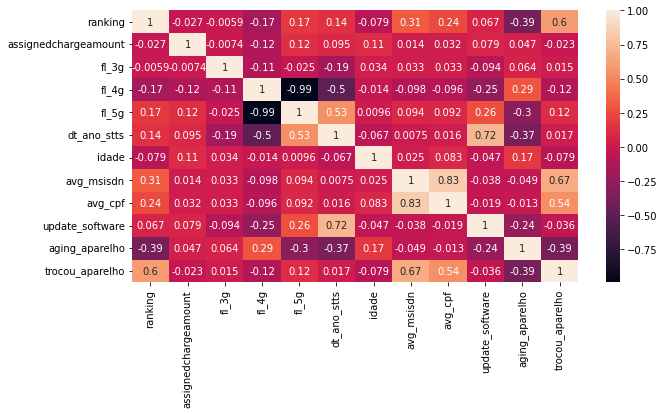

In [29]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

***
***
***
## Definição do Target trocou_aparelho

In [30]:
def plot_feature_freq(df, feature, qt_cat):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    order = np.argsort(counts)[::-1]
    labels, counts = labels[order], counts[order]

    g = sns.barplot(labels[:qt_cat], counts[:qt_cat])
    g.set_xticklabels(labels[:qt_cat], rotation=90)
    
    return g

In [31]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 39855, 1: 18441})

<AxesSubplot:>

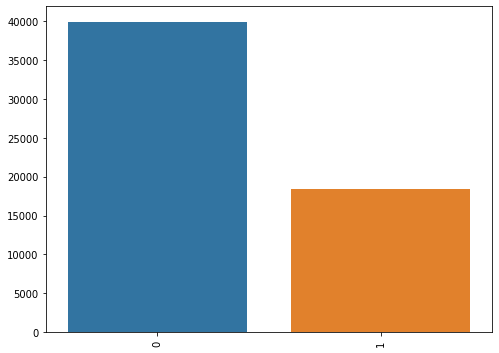

In [32]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho', len(dados_droped['trocou_aparelho'].unique()))

***
## Modelagem trocou_aparelho

In [33]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_ta[numerical_cols_ta] = scaler.fit_transform(X_ta[numerical_cols_ta])

In [34]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

In [35]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train_ta = X_train_ta.copy()
label_X_valid_ta = X_val_ta.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder_ta = OrdinalEncoder()
label_X_train_ta[object_cols_ta] = ordinal_encoder_ta.fit_transform(label_X_train_ta[object_cols_ta])
label_X_valid_ta[object_cols_ta] = ordinal_encoder_ta.fit_transform(label_X_valid_ta[object_cols_ta])

In [36]:
model_ta = GradientBoostingClassifier(random_state=2048)
model_ta.fit(label_X_train_ta, y_train_ta)
preds_ta = model_ta.predict(label_X_valid_ta)

***
### Feature Importance

In [37]:
import eli5
from eli5.sklearn import PermutationImportance

perm_ta = PermutationImportance(model_ta, n_iter=100).fit(label_X_valid_ta, y_val_ta)
eli5.show_weights(perm_ta, feature_names = label_X_valid_ta.columns.tolist())

Weight,Feature
0.2919 ± 0.0036,avg_msisdn
0.1296 ± 0.0022,ranking
0.0240 ± 0.0010,aging_aparelho
0 ± 0.0000,update_software
0 ± 0.0000,assignedchargeamount
0 ± 0.0000,modelo
0 ± 0.0000,offertechnology
0 ± 0.0000,statedesc
0 ± 0.0000,subscribermainofferdesc
0 ± 0.0000,fl_3g


Permutation explainer: 29149it [37:36, 12.88it/s]                           


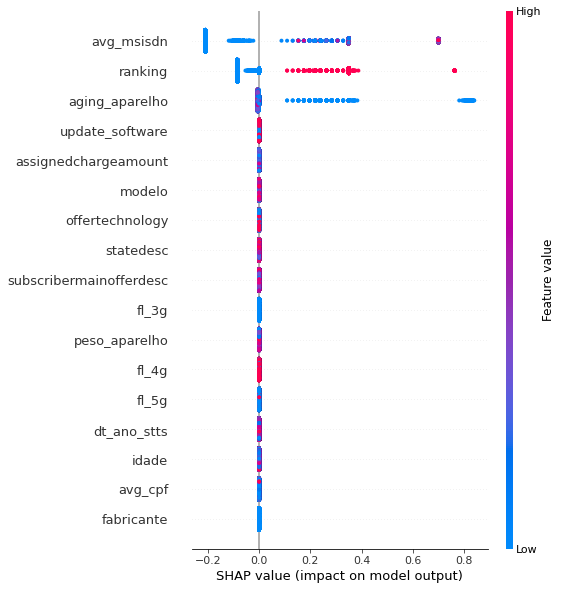

In [38]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer_ta = shap.Explainer(model_ta.predict, label_X_valid_ta)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values_ta = explainer_ta(label_X_valid_ta)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values_ta, label_X_valid_ta)

  0%|          | 0/2914 [00:00<?, ?it/s]

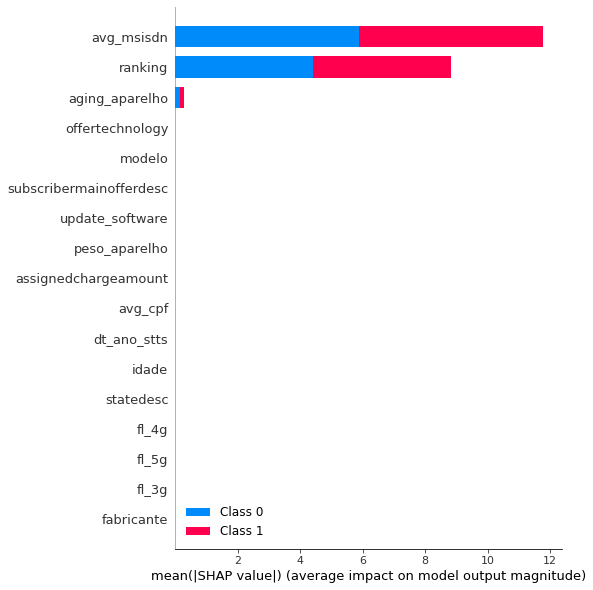

In [39]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample_ta = label_X_train_ta.sample(n=min(10, len(label_X_train_ta.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example_ta = label_X_valid_ta.sample(n=int((label_X_valid_ta.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict_ta = lambda x: model_ta.predict_proba(pd.DataFrame(x, columns=label_X_train_ta.columns))
explainer_ta2 = KernelExplainer(predict_ta, train_sample_ta, link="logit")
shap_values_ta2 = explainer_ta2.shap_values(example_ta, l1_reg=False)
summary_plot(shap_values_ta2, example_ta)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)

***
## Métricas

In [40]:
print(classification_report(y_val_ta, preds_ta))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19958
           1       1.00      1.00      1.00      9190

    accuracy                           1.00     29148
   macro avg       1.00      1.00      1.00     29148
weighted avg       1.00      1.00      1.00     29148



In [41]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,19958,0
1,0,9190


Confusion matrix, without normalization
[[19958     0]
 [    0  9190]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


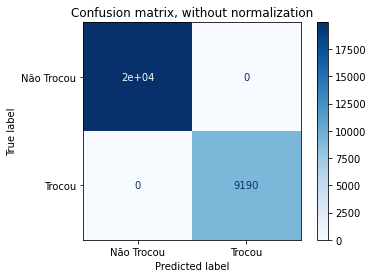

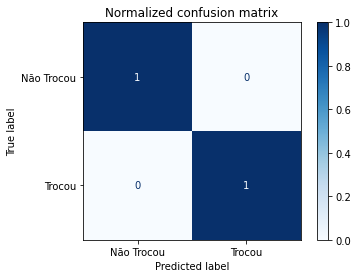

<Figure size 1296x1296 with 0 Axes>

In [42]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model_ta,
        label_X_valid_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

In [43]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

<AxesSubplot:>

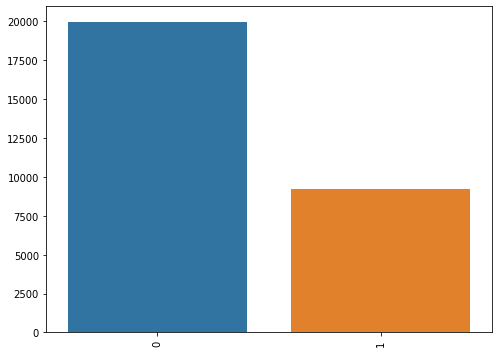

In [44]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho', len(X_val_ta['trocou_aparelho'].unique()))

In [45]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

<AxesSubplot:>

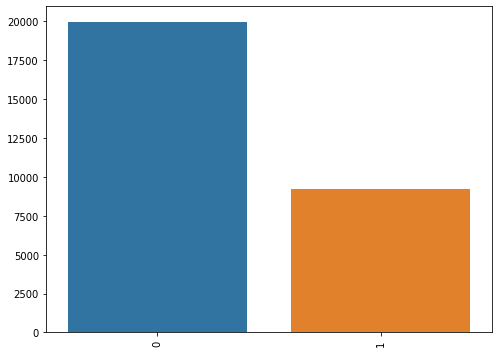

In [46]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto', len(X_val_ta['trocou_aparelho_previsto'].unique()))

In [47]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [48]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [49]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
# X_val_ta

In [50]:
X_val_ta['aging_aparelho_ori'] = dados_droped['aging_aparelho']
X_val_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,...,avg_msisdn,avg_cpf,peso_aparelho,update_software,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,aging_aparelho_ori
428,APPLE,IPHONE 11 (A2221),-0.406743,-0.588421,PostPaid,RIO GRANDE DO SUL,LINHA ADICIONAL VIVO FAMILIA 150GB,-0.846071,0,1,...,0.442508,1.583062,2221,0.567604,1,1,9.449713e+10,2021-05-01,2022-03-07,10
925,APPLE,IPHONE XR (A2105),-0.406743,-0.517597,PostPaid,SAO PAULO,TITULAR BASICO FUNCIONAL,-0.846071,0,1,...,-0.456386,-0.541140,2105,0.567604,0,0,4.226574e+10,2021-11-05,NaN,11
46537,APPLE,IPHONE 11 (A2221),-0.406743,1.182171,Controle,SAO PAULO,VIVO CONTROLE 9GB I,-0.162620,0,1,...,-0.456386,-0.541140,2221,0.567604,0,0,2.736211e+10,2019-10-27,NaN,35
13873,APPLE,IPHONE 11 (A2221),-0.406743,-0.517597,Controle,SAO PAULO,VIVOCONTROLEDIGITAL-14GB ILIM_,0.112700,0,1,...,-0.456386,-0.541140,2221,0.567604,0,0,1.590943e+09,2021-11-19,NaN,11
8681,APPLE,IPHONE 11 (A2111),1.477065,-0.942539,Controle,CEARA,VIVO CONTROLE 5GB II,-0.395397,0,1,...,-0.006939,-0.121835,2111,0.567604,1,1,6.817178e+09,2022-04-21,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57779,APPLE,IPHONE 13 PRO MAX (A2643),1.477065,-0.800892,PostPaid,BAHIA,LINHA ADICIONAL VIVO V,-0.846071,0,0,...,-0.186718,-0.163765,2643,0.567604,1,1,3.573084e+09,2022-03-13,NaN,7
8561,APPLE,IPHONE 11 (A2221),-0.406743,0.190639,Controle,SAO PAULO,VIVO CONTROLE 4GB,-0.486656,0,1,...,-0.456386,-0.541140,2221,0.567604,0,0,4.127596e+10,2020-12-23,NaN,21
28167,APPLE,IPHONE 6S (A1688),-0.406743,-1.084187,PostPaid,AMAZONAS,Linha Adicional Vivo Pós Família 300GB,-0.846071,0,1,...,-0.186718,-0.205696,1688,-1.761791,1,1,5.227714e+10,2022-01-15,2022-05-07,3
21298,APPLE,IPHONE 13 (A2633),1.477065,-0.942539,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 60GB PLN,0.421416,0,0,...,6.824650,6.251610,2633,0.567604,1,1,3.957453e+09,2022-05-05,NaN,5


***
***
***
## Separando as bases para outro modelo

In [51]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,...,avg_msisdn,avg_cpf,peso_aparelho,update_software,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,aging_aparelho_ori
0,APPLE,IPHONE 11 (A2221),-0.406743,-0.588421,PostPaid,RIO GRANDE DO SUL,LINHA ADICIONAL VIVO FAMILIA 150GB,-0.846071,0,1,...,0.442508,1.583062,2221,0.567604,1,1,9.449713e+10,2021-05-01,2022-03-07,10
1,APPLE,IPHONE 11 (A2111),1.477065,-0.942539,Controle,CEARA,VIVO CONTROLE 5GB II,-0.395397,0,1,...,-0.006939,-0.121835,2111,0.567604,1,1,6.817178e+09,2022-04-21,NaN,5
2,APPLE,IPHONE XR (A1984),1.477065,-1.013363,Controle,MINAS GERAIS,VIVO CONTROLE 6GB III,-0.284079,0,1,...,0.532397,0.381332,1984,0.567604,1,1,1.499001e+10,2022-06-13,NaN,4
3,APPLE,IPHONE 8 (A1905),-0.406743,-0.942539,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 100GB,-0.846071,0,1,...,-0.006939,0.912173,1905,0.567604,1,1,8.818342e+09,2021-10-02,2022-03-23,5
4,APPLE,IPHONE 12 PRO MAX (A2342),1.477065,-0.730068,PostPaid,BAHIA,TITULAR VIVO_POS 30GB,-0.324748,0,0,...,1.251512,1.052221,2342,0.567604,1,1,4.083753e+09,2022-02-12,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9185,APPLE,IPHONE 7 PLUS (A1784),-0.406743,3.094410,PostPaid,RIO GRANDE DO SUL,Titular Vivo Pós 20GB,-0.306122,0,1,...,5.116753,4.658249,1784,-1.761791,1,1,5.956019e+10,2017-03-15,2022-05-18,62
9186,APPLE,IPHONE 13 PRO MAX (A2643),1.477065,-0.800892,PostPaid,BAHIA,LINHA ADICIONAL VIVO V,-0.846071,0,0,...,-0.186718,-0.163765,2643,0.567604,1,1,3.573084e+09,2022-03-13,NaN,7
9187,APPLE,IPHONE 6S (A1688),-0.406743,-1.084187,PostPaid,AMAZONAS,Linha Adicional Vivo Pós Família 300GB,-0.846071,0,1,...,-0.186718,-0.205696,1688,-1.761791,1,1,5.227714e+10,2022-01-15,2022-05-07,3
9188,APPLE,IPHONE 13 (A2633),1.477065,-0.942539,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 60GB PLN,0.421416,0,0,...,6.824650,6.251610,2633,0.567604,1,1,3.957453e+09,2022-05-05,NaN,5


***
***
***
## Definição do Target aging_aparelho

In [52]:
# define target
y = base_to_pred_month['aging_aparelho_ori']

In [53]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({10: 109,
         5: 1417,
         4: 1512,
         8: 609,
         6: 1203,
         11: 105,
         60: 4,
         14: 112,
         7: 930,
         29: 58,
         13: 87,
         44: 20,
         2: 224,
         68: 1,
         46: 23,
         52: 11,
         30: 55,
         15: 77,
         0: 443,
         12: 101,
         28: 76,
         32: 37,
         3: 209,
         47: 14,
         76: 1,
         34: 36,
         48: 16,
         1: 190,
         54: 8,
         43: 22,
         67: 4,
         16: 100,
         20: 90,
         37: 39,
         9: 138,
         23: 51,
         18: 80,
         41: 33,
         31: 38,
         42: 19,
         59: 8,
         21: 62,
         40: 34,
         26: 77,
         19: 82,
         58: 7,
         55: 4,
         39: 30,
         27: 76,
         17: 79,
         56: 12,
         25: 64,
         36: 42,
         24: 48,
         35: 30,
         71: 2,
         33: 26,
         38: 29,
         57: 10

<AxesSubplot:>

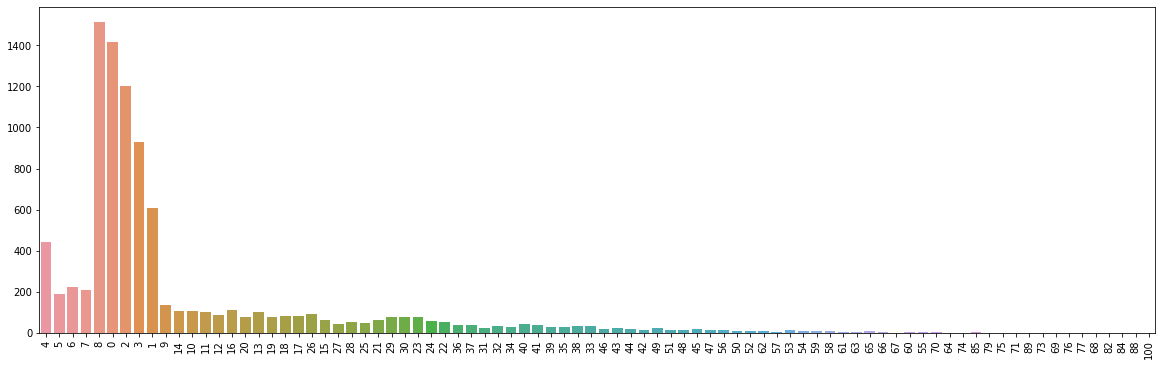

In [54]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho_ori', len(base_to_pred_month['aging_aparelho_ori'].unique()))

### Definicão das features

In [55]:
# define features
X = base_to_pred_month[['fabricante', 'modelo',
                        'ranking',
                        'offertechnology', 
                        'statedesc', 'subscribermainofferdesc',
                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                        'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf']]
X

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,APPLE,IPHONE 11 (A2221),-0.406743,PostPaid,RIO GRANDE DO SUL,LINHA ADICIONAL VIVO FAMILIA 150GB,-0.846071,0,1,0,0.271012,50,0.442508,1.583062
1,APPLE,IPHONE 11 (A2111),1.477065,Controle,CEARA,VIVO CONTROLE 5GB II,-0.395397,0,1,0,1.318928,21,-0.006939,-0.121835
2,APPLE,IPHONE XR (A1984),1.477065,Controle,MINAS GERAIS,VIVO CONTROLE 6GB III,-0.284079,0,1,0,0.271012,23,0.532397,0.381332
3,APPLE,IPHONE 8 (A1905),-0.406743,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 100GB,-0.846071,0,1,0,-0.776904,58,-0.006939,0.912173
4,APPLE,IPHONE 12 PRO MAX (A2342),1.477065,PostPaid,BAHIA,TITULAR VIVO_POS 30GB,-0.324748,0,0,1,0.794970,34,1.251512,1.052221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9185,APPLE,IPHONE 7 PLUS (A1784),-0.406743,PostPaid,RIO GRANDE DO SUL,Titular Vivo Pós 20GB,-0.306122,0,1,0,-1.300863,53,5.116753,4.658249
9186,APPLE,IPHONE 13 PRO MAX (A2643),1.477065,PostPaid,BAHIA,LINHA ADICIONAL VIVO V,-0.846071,0,0,1,1.318928,35,-0.186718,-0.163765
9187,APPLE,IPHONE 6S (A1688),-0.406743,PostPaid,AMAZONAS,Linha Adicional Vivo Pós Família 300GB,-0.846071,0,1,0,-1.300863,41,-0.186718,-0.205696
9188,APPLE,IPHONE 13 (A2633),1.477065,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 60GB PLN,0.421416,0,0,1,1.318928,60,6.824650,6.251610


#### Variaveis Categoricas

In [56]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [57]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  5
['ranking', 'assignedchargeamount', 'dt_ano_stts', 'avg_msisdn', 'avg_cpf']


***
## Mostrando a correlação entre os dados numéricos

In [58]:
corr_mes_previsao = base_to_pred_month[['fabricante', 'modelo',
                                        'ranking',
                                        'offertechnology', 
                                        'statedesc', 'subscribermainofferdesc',
                                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                        'dt_ano_stts', 'idade', 'aging_aparelho_ori', 'avg_msisdn', 'avg_cpf']]

<AxesSubplot:>

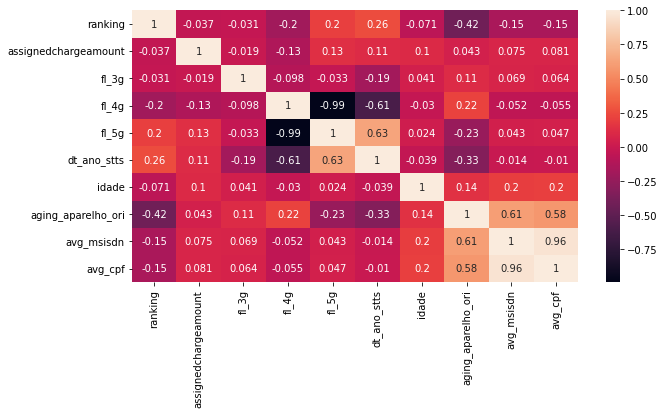

In [59]:
corr2 = corr_mes_previsao.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr2, xticklabels = corr2.columns, yticklabels = corr2.columns, annot = True)

***
## Modelagem

In [60]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [61]:
# Dividindo as features em dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

In [62]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_val.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.fit_transform(label_X_valid[object_cols])

model = GradientBoostingClassifier(random_state=2048)
model.fit(label_X_train, y_train)
preds = model.predict(label_X_valid)

***
### Feature Importance

In [63]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, n_iter=100).fit(label_X_valid, y_val)
eli5.show_weights(perm, feature_names = label_X_valid.columns.tolist())


Weight,Feature
0.2137 ± 0.0079,avg_msisdn
0.1484 ± 0.0083,ranking
0.0592 ± 0.0071,avg_cpf
0.0101 ± 0.0059,subscribermainofferdesc
0.0063 ± 0.0059,assignedchargeamount
0.0009 ± 0.0040,dt_ano_stts
0.0002 ± 0.0040,statedesc
0.0001 ± 0.0006,offertechnology
0.0000 ± 0.0004,fabricante
-0.0000 ± 0.0001,fl_3g


In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.Explainer(model.predict, label_X_valid)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer(label_X_valid)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, label_X_valid)

Permutation explainer:  20%|█▉        | 908/4595 [44:14<3:02:53,  2.98s/it]

In [ ]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = label_X_train.sample(n=min(10, len(label_X_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = label_X_valid.sample(n=int((label_X_valid.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=label_X_train.columns))
explainer2 = KernelExplainer(predict, train_sample, link="logit")
shap_values2 = explainer2.shap_values(example, l1_reg=False)
summary_plot(shap_values2, example)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)

***
## Métricas

In [ ]:
print(classification_report(y_val, preds))

In [ ]:
cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
                     index = sorted(Counter(y_val)),
                     columns = sorted(Counter(preds)))
cm_df

## Plot non-normalized confusion matrix

In [ ]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        label_X_valid,
        y_val,
        display_labels=y.unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [ ]:
X_val['aging_aparelho'] = y_val
# X_val

In [ ]:
X_val['previsto'] = preds
# X_val

In [ ]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [ ]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [ ]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [ ]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

In [ ]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'aging_aparelho', len(X_val['aging_aparelho'].unique()))

In [ ]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'previsto', len(X_val['previsto'].unique()))